<a href="https://colab.research.google.com/github/kd303/examples/blob/master/PyTorchAssginment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement:

We are to solve for a neural network which outputs a sum of  an image of a number between **0 & 9** and also a *random number generated* between **0 & 9** 


Nueral nets are not great at solving linear equations, this is an excersize in understanding **PyTorch** Data Loader and built an intution on nural net and their working.

  
### **Following Image shows a sample of what we are trying to achieve:**
---
5 is an image and 7 is a generated number, which gives two outputs number that is recongnized by NN and 13 is a sum of two input numbers

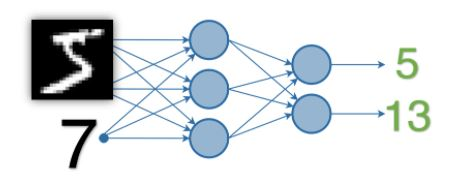


## Lets start with DataSet and Data Loader creation..

In [3]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

In [5]:
train_data = datasets.MNIST(root = './data', 
               download=True, 
               transform = transforms.Compose([transforms.ToTensor()]),
               train = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
train_loader = torch.utils.data.DataLoader(train_data
    ,batch_size=32
    ,shuffle=True
)

In [47]:
import random

print(random.randrange(0,9))

8


In [54]:
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from PIL import Image
import random as r
from typing import Any, Callable, Dict, List, Optional, Tuple

In [61]:
class MyDataset(MNIST):
  def __init__(
      self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    )-> None :
    super(MyDataset, self).__init__(root, transform=transform, 
                                    target_transform = target_transform,
                                    download = download,
                                    train = train)
   
  def __getitem__(self, index):
    
    img, target = self.data[index], int(self.targets[index])

    # doing this so that it is consistent with all other datasets
    # to return a PIL Image
    img = Image.fromarray(img.numpy(), mode='L')

    rand_input = r.randrange(0,9)

    rand_sum = rand_input + int(target)


    if self.transform is not None:
        img = self.transform(img)

    if self.target_transform is not None:
        target = self.target_transform(target)

    return img, target, rand_input, rand_sum

  def __len__(self):
    return len(self.data)

In [62]:
train_data = MyDataset(root = './data', 
               download=True, 
               transform = transforms.Compose([transforms.ToTensor()]),
               train = True)

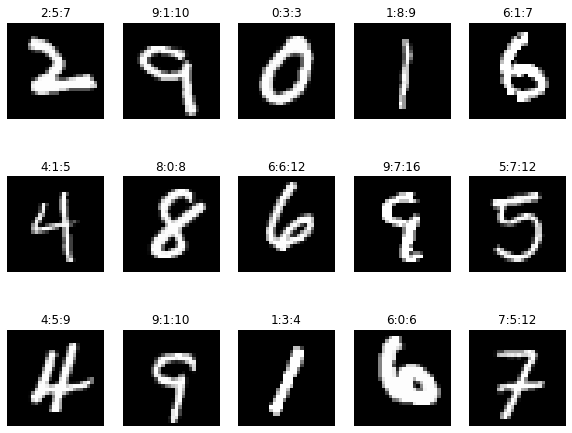

In [63]:
# Data visualization

import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label, ran_input, ran_sum = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label) +':' + str(ran_input) + ':' + str(ran_sum))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Lets Define the model 

We are looking something following logically


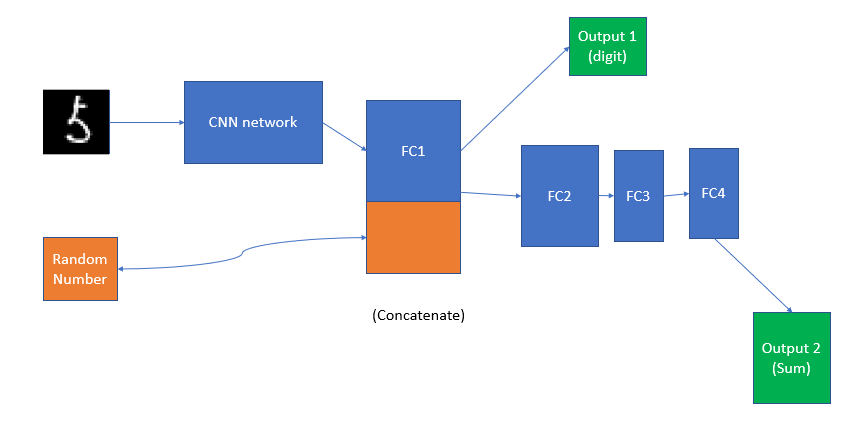

In [12]:
import torch.nn as nn

In [64]:
class CustomCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    self.fc1 = nn.Linear(in_features=212, out_features=212)
    self.fc2 = nn.Linear(in_features=212, out_features=100)
    self.fc3 = nn.Linear(in_features=100, out_features=29)
    self.preprocess_rand1 = nn.Linear(in_features = 10, out_features=20)
    self.out = nn.Linear(in_features=60, out_features=10)
  
  def forward(self, t):
    # input layer, t will have [image, img_label, ran_input, rand_sum]
    x = t[0]
    rand_input = t[2] 
    # conv1 layer
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

    # conv2 layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

    # reshape
    x = x.reshape(-1, 12 * 4 * 4)

    # preprocess the random input
    y = self.preprocess_rand1(rand_input)    
    y = F.relu(y)

    # Concate two inputs from Fc1 and rand_input
    x1 = torch.cat((x, y), dim=1)

     # fc1 layer
    x1 = self.fc1(x1)
    x1 = F.relu(x1)


    # fc2 layer
    x1 = self.fc2(x1)
    x1 = F.relu(x1)
    
    # fc3 layer
    x1 = self.fc3(x1)
    x1 = F.relu(x1)

    # output layer  
    x1 = self.out(x1)
    x1 = F.softmax(x1, dim=1)
    return x1

In [32]:
cnn = CustomCNN()
loss = nn.CrossEntropyLoss()

print(cnn)
print(loss)

CustomCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)
CrossEntropyLoss()


In [33]:
from torch import optim
import torch.nn.functional as F

optimizer = optim.Adam(cnn.parameters(), lr = 0.01)


In [34]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [36]:
train_loader = torch.utils.data.DataLoader(train_data
    ,batch_size=100
    ,shuffle=True
)

In [37]:
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

for epoch in range(10):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = cnn(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 6742 loss: 1409.2703123092651
epoch 1 total_correct: 6742 loss: 1409.2703087329865
epoch 2 total_correct: 6742 loss: 1409.2703080177307
epoch 3 total_correct: 6742 loss: 1409.2703156471252
epoch 4 total_correct: 6742 loss: 1409.2703170776367
epoch 5 total_correct: 6742 loss: 1409.2703123092651
epoch 6 total_correct: 6742 loss: 1409.2703127861023
epoch 7 total_correct: 6742 loss: 1409.2703132629395
epoch 8 total_correct: 6742 loss: 1409.2703115940094
epoch 9 total_correct: 6742 loss: 1409.270314693451
